# Exam Preparation Deep Learning
18.03.2022, Thomas Iten

## 3. CNN

### 3.1 Initialization

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor


#
# Setup device (cuda / cpu)
#
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Device:")
print(device)

Device:
cpu


### 3.2 Download data

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()                           # ToTensor() erstellt proprietäres Format für PyTorch

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### 3.3 Explore data

In [3]:
print("#")
print("# Train Data")
print("#")
print(train_data)

print("\n#")
print("# Train Data Classes")
print("#")
print(train_data.classes)
print()

print("\n#")
print("# Train Data ClassToIndex")
print("#")
print(train_data.class_to_idx)

#
# Train Data
#
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

#
# Train Data Classes
#
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#
# Train Data ClassToIndex
#
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


### 3.4 Create Data Loader

In [4]:
batch_size = 20
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader  = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([20, 1, 28, 28])
Shape of y:  torch.Size([20]) torch.int64


### 3.5 Show classes and images

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# specify the image classes
classes = datasets.FashionMNIST.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


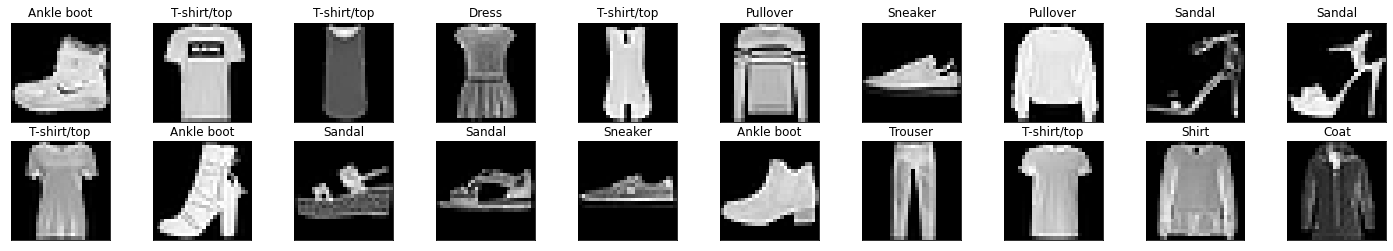

In [6]:
# obtain one batch of training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
    img = images[idx][0]
    plt.imshow(img, cmap='gray')
    ax.set_title(classes[labels[idx]])

### 3.6 CNN

In [7]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        #
        # encoder layers
        #
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)             # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)             # conv layer (depth from 16 --> 4), 3x3 kernels
        self.pool  = nn.MaxPool2d(2, 2)                         # pooling layer to reduce x-y dims by two;
                                                                # kernel and stride of 2

        #
        # decoder layers
        #
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)   # a kernel of 2 and a stride of 2
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)   # will increase the spatial dims by 2

    def forward(self, x):
        #
        # encode
        #
        x = F.relu(self.conv1(x))                               # add hidden layers with relu activation function
        x = self.pool(x)                                        # and maxpooling after
        x = F.relu(self.conv2(x))                               # add second hidden layer
        x = self.pool(x)                                        # compressed representation
        #
        # decode
        #
        x = F.relu(self.t_conv1(x))                             # transpose conv layers, with relu activation function
        x = F.sigmoid(self.t_conv2(x))                          # output layer (with sigmoid for scaling from 0 to 1)

        return x


# initialize the CNN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


### 3.7 Loss und Optimizer

In [8]:
# Backward
# - Definition Backward Loss Funktion
# - Build partial derivates of loss function and grads
loss_fn = nn.BCELoss()

# Step
# - Optimizer aktualisiert die Gewichte
# - Der optimizer macht den Update step intelligenter
# - Update: params = params - learing_rate * grad
# - Besser ist Adam optimizer
#   optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 3.8 Training

In [9]:
# number of epochs to train the model
epochs = 3

for epoch in range(epochs):
    train_loss = 0.0                            # monitor training loss

    for data in train_dataloader:               # train the model

        # get images
        images, _ = data                        # no need to flatten images
                                                # _ stands in for labels (y), here

        # forward pass
        outputs = model(images)                 # compute predicted outputs by passing inputs to the model
        loss = loss_fn(outputs, images)         # calculate the loss

        # backward pass
        optimizer.zero_grad()                   # clear the gradients of all optimized variables
        loss.backward()                         # compute gradient of the loss with respect to model parameters
        optimizer.step()                        # perform a single optimization step (parameter update)

        # update running training loss
        train_loss += loss.item() * images.size(0)

    # print avg training statistics
    train_loss = train_loss / len(train_dataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,train_loss))

print("Done!")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	Training Loss: 6.457468
Epoch: 1 	Training Loss: 5.830968
Epoch: 2 	Training Loss: 5.688905
Done!


### 3.9 Plot images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


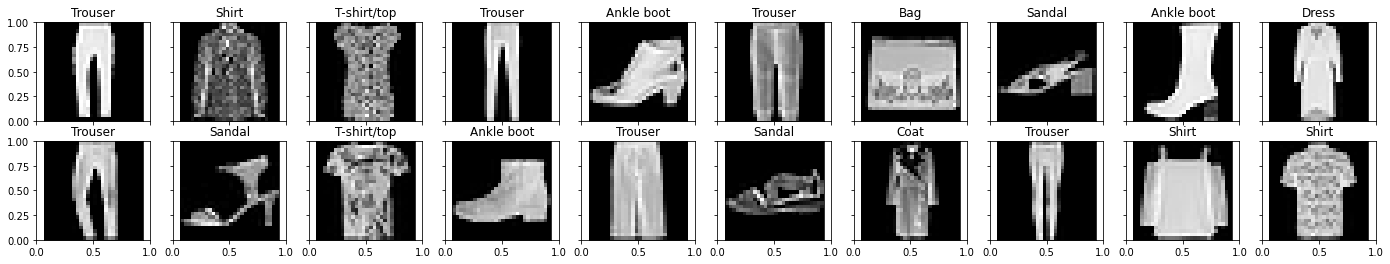

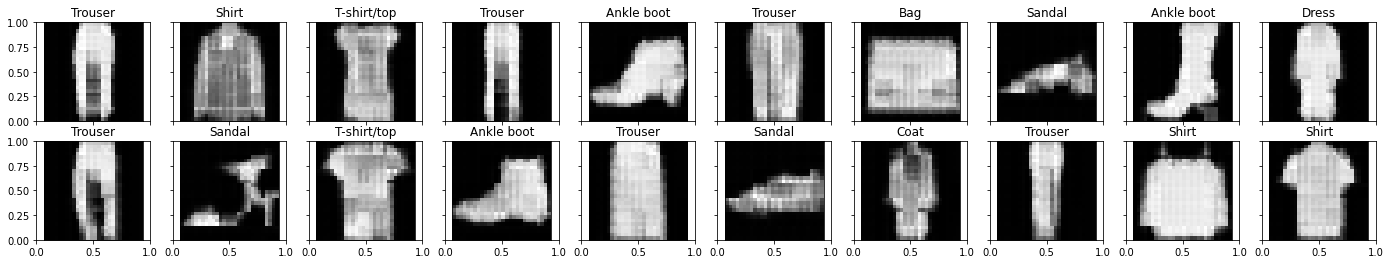

In [10]:
# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()


# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
def plot_images(images, n=20, nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24, 4)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=sharex, sharey=sharey, figsize=figsize)
    for idx in np.arange(n):
        ax = fig.add_subplot(nrows, ncols, idx + 1, xticks=[], yticks=[])
        img = images[idx][0]
        plt.imshow(img, cmap='gray')
        ax.set_title(classes[labels[idx]])


plot_images(images, n=20, nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24, 4))
plot_images(output, n=20, nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24, 4))

#### _The end._
